In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from scipy import ndimage

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
CUBE_PATH = "../sdss_cube_sfr/SDSS_cube_lean.h5"

with h5py.File(CUBE_PATH, "r") as cube:
    spectra = cube["dense_cube/0/ml_spectrum/spectral_1d_cube_zoom_0"][:]
    images = cube["dense_cube/0/ml_image/cutout_3d_cube_zoom_0"][:]
    metadata = cube["dense_cube/0/ml_spectrum/spec_metadata_refs"][:]

sfrs = pd.read_hdf(CUBE_PATH, key="fits_spectra_metadata_star_formation_rates")
valid_sfrs = sfrs[(sfrs["FLAG"] == 0.0) & (sfrs["Z"].notna())].copy()

In [3]:
metadata_indices = metadata[:, 0]["ds_slice_idx"]
mask = np.in1d(metadata_indices, valid_sfrs.index)

In [4]:
with h5py.File(CUBE_PATH, "r") as cube:
    spectra_zoom0 = cube["dense_cube/0/ml_spectrum/spectral_1d_cube_zoom_0"][:][mask]
    images_zoom0 = cube["dense_cube/0/ml_image/cutout_3d_cube_zoom_0"][:][mask]

metadata_indices_filtered = metadata_indices[mask]
labels = valid_sfrs.loc[metadata_indices_filtered, "TARGETTYPE"]    

In [5]:
def simplify_targettype(val):
    if isinstance(val, bytes):
        val = val.decode("utf-8").strip()
    else:
        val = str(val).strip()
    return "GALAXY" if "GALAXY" in val else "OTHER"

In [6]:
labels_simplified = pd.Series(labels).apply(simplify_targettype).values
galaxy_mask = labels_simplified == "GALAXY"

valid_indices = ~np.isnan(spectra_zoom0).any(axis=1)

final_mask = galaxy_mask & valid_indices
print("Final obj number:", final_mask.sum())

Final obj number: 10126


In [7]:
Y = valid_sfrs.loc[metadata_indices_filtered, "AVG"].values
Y = Y[final_mask]

In [8]:
filters = ["u", "g", "r", "i", "z"]

all_images = []
all_spectra = []

for zoom in range(4):
    img_key = f"dense_cube/{zoom}/ml_image/cutout_3d_cube_zoom_{zoom}"
    spec_key = f"dense_cube/{zoom}/ml_spectrum/spectral_1d_cube_zoom_{zoom}"
    
    with h5py.File(CUBE_PATH, "r") as cube:
        images_zoom = cube[img_key][:][mask]
        spectra_zoom = cube[spec_key][:][mask]
   
    images_zoom = images_zoom[final_mask]
    spectra_zoom = spectra_zoom[final_mask]
    
    if zoom == 0:
        reference_spectrum = spectra_zoom.copy()
        reference_images = images_zoom.copy()
    
    min_val_spec = np.min(reference_spectrum, axis=1, keepdims=True)
    max_val_spec = np.max(reference_spectrum, axis=1, keepdims=True)
    spectra_zoom_normalized = 2 * (spectra_zoom - min_val_spec) / (max_val_spec - min_val_spec) - 1
    
    min_val_img = np.min(reference_images, axis=(2, 3), keepdims=True)
    max_val_img = np.max(reference_images, axis=(2, 3), keepdims=True)
    images_zoom_normalized = 2 * (images_zoom - min_val_img) / (max_val_img - min_val_img) - 1
    
    all_images.append(images_zoom_normalized)
    all_spectra.append(spectra_zoom_normalized)

In [9]:
def detect_and_visualize_multiple_objects(all_images, thresholds, max_objects=20, thumbnail_size=3, crop_sizes=None):
    all_images_trimmed = []
    for i, img_array in enumerate(all_images):
        original_size = img_array.shape[-1]
        target_size = crop_sizes.get(i, original_size)
        
        start = (original_size - target_size) // 2
        end = start + target_size
        
        trimmed = img_array[..., start:end, start:end]
        all_images_trimmed.append(trimmed)
    
    multi_obj_indices = []
    for idx in range(all_images_trimmed[0].shape[0]):
        image = all_images_trimmed[0][idx, 2, :, :]
        image_normalized = (image + 1) / 2
        binary = image_normalized > thresholds[0]
        labeled, num_features = ndimage.label(binary)
        if num_features > 1:
            multi_obj_indices.append(idx)

    if len(multi_obj_indices) > max_objects:
        print(f"Found {len(multi_obj_indices)} objects. Showing first {max_objects}")
        multi_obj_indices = multi_obj_indices[:max_objects]

    if not multi_obj_indices:
        print("No multi-object sources found")
        return all_images_trimmed
    
    num_rows = len(multi_obj_indices)
    fig, axes = plt.subplots(
        num_rows,
        5,
        figsize=(15, thumbnail_size * num_rows),
        dpi=100
    )
    
    if num_rows == 1:
        axes = axes.reshape(1, -1)

    for row, obj_idx in enumerate(multi_obj_indices):
        for col in range(5):
            ax = axes[row, col]
            img_data = all_images_trimmed[0][obj_idx, col, :, :]
            ax.imshow(img_data, vmin=-1, vmax=1)
            ax.set_title(f"Filter {filters[col]}")
            ax.axis("off")

    plt.tight_layout()
    plt.show()
    return all_images_trimmed

## 50% crop:

In [10]:
THRESHOLDS_4 = {
    0: 0.90,
    1: 0.93,
    2: 0.97,
    3: 0.99
}

CROP_SIZES_4 = {
    0: 32, 
    1: 16, 
    2: 8, 
    3: 4   
}

In [11]:
cropped_images = []
for zoom in range(4):
    img_array = all_images[zoom]
    original_size = img_array.shape[-1]
    target_size = CROP_SIZES_4.get(zoom, original_size)
    start = (original_size - target_size) // 2
    end = start + target_size
    cropped = img_array[..., start:end, start:end]
    cropped_images.append(cropped)

/tmp/ipykernel_1224877/3373114291.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


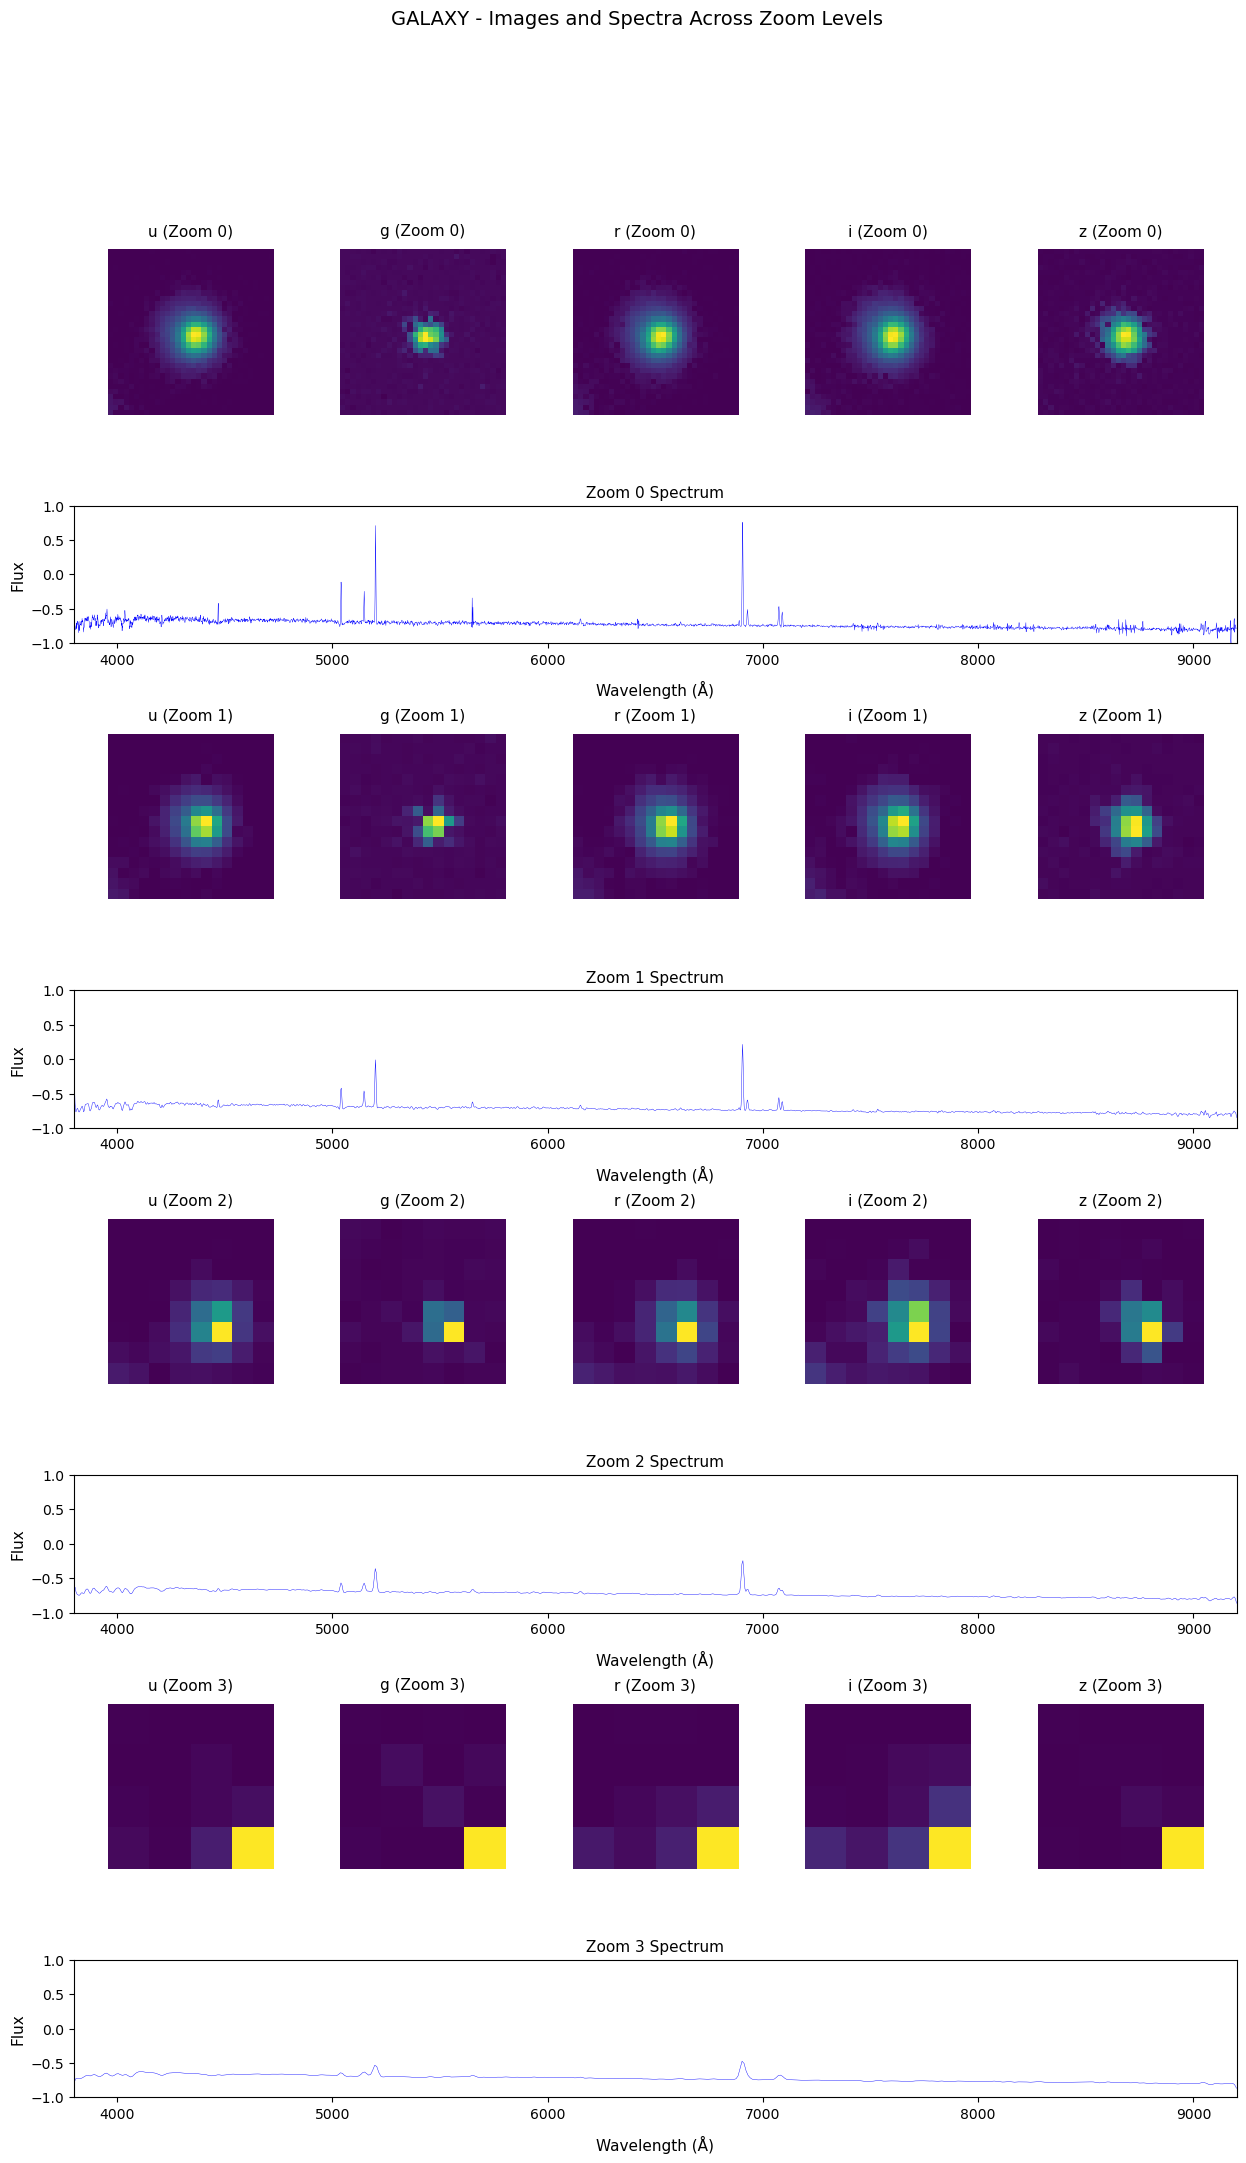

In [12]:
def plot_images_and_spectrum(images, spectra, labels, class_name, obj_num):
    class_index = np.where(labels == class_name)[0]
    if len(class_index) == 0:
        print(f"No images found for class: {class_name}")
        return
    if obj_num >= len(class_index):
        print(f"Object index {obj_num} is out of range. Max available: {len(class_index)-1}")
        return

    idx = class_index[obj_num]
    if len(images) < 4 or len(spectra) < 4:
        print(f"Expected 4 zoom levels, but got {len(images)} images and {len(spectra)} spectra.")
        return

    fig = plt.figure(figsize=(15, 24))
    gs = gridspec.GridSpec(8, 5, height_ratios=[1.2, 1.0, 1.2, 1.0, 1.2, 1.0, 1.2, 1.0], 
                           hspace=0.6, wspace=0.0)

    for zoom in range(4):
        if idx >= len(images[zoom]):
            print(f"Index {idx} is out of bounds for zoom {zoom} images.")
            continue

        img_channels = images[zoom][idx]
        spectrum = spectra[zoom][idx]

        for i in range(5):
            ax = fig.add_subplot(gs[zoom * 2, i])
            ax.imshow(img_channels[i], cmap="viridis")
            ax.set_title(f"{filters[i]} (Zoom {zoom})", fontsize=11, pad=10)
            ax.axis("off")

        ax_spec = fig.add_subplot(gs[zoom * 2 + 1, :])
        zoom_wavelengths = np.linspace(3800, 9200, len(spectrum))
        ax_spec.plot(zoom_wavelengths, spectrum, color="blue", linewidth=0.3)
        ax_spec.set_title(f"Zoom {zoom} Spectrum", fontsize=11)
        ax_spec.set_xlabel("Wavelength (Å)", fontsize=11, labelpad=10)
        ax_spec.set_ylabel("Flux", fontsize=11)
        ax_spec.set_xlim([3800, 9200])
        ax_spec.set_ylim([-1, 1]) 

    fig.suptitle(f"{class_name} - Images and Spectra Across Zoom Levels", fontsize=14)
    plt.tight_layout()
    plt.show()

# Вызов функции без redshifts
for i in range(1):
    plot_images_and_spectrum(cropped_images, all_spectra, labels_simplified, "GALAXY", i)

## Visualisation

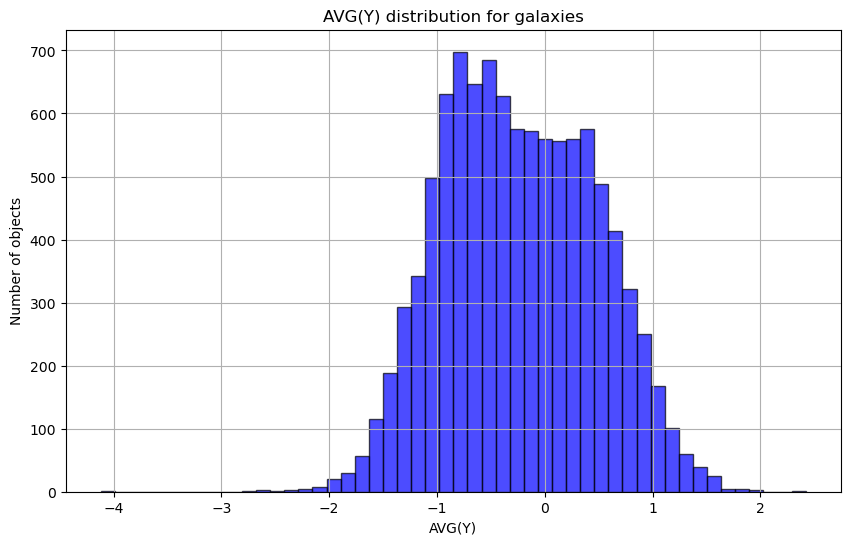

In [13]:
plt.figure(figsize=(10, 6))
plt.hist(Y, bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.title("AVG(Y) distribution for galaxies")
plt.xlabel("AVG(Y)")
plt.ylabel("Number of objects")
plt.grid(True)
plt.show()

## Decision Tree

## Images

In [14]:
results_images = {}
for zoom in range(4):
    # Get features for the current zoom level and flatten each image
    X_img = cropped_images[zoom]
    n_samples = X_img.shape[0]
    X_img = X_img.reshape(n_samples, -1)
    
    # Ensure that the number of samples in X_img and Y match
    assert X_img.shape[0] == Y.shape[0], f"Sample mismatch at zoom {zoom}: X_img has {X_img.shape[0]} samples, Y has {Y.shape[0]} samples."
    
    # Split the data into train (60%) and temp (40%), then split temp into validation and test sets (20% each)
    X_train, X_temp, y_train, y_temp = train_test_split(X_img, Y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    # Define the parameter grid for the DecisionTreeRegressor
    param_grid = {
        "max_depth": [5, 7],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [2, 4]
    }
    dt = DecisionTreeRegressor(random_state=42)
    grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_dt = grid_search.best_estimator_
    y_test_pred = best_dt.predict(X_test)
    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    results_images[zoom] = {
        "best_params": grid_search.best_params_,
        "mse_test": mse_test,
        "r2_test": r2_test
    }
    print(f"Images Zoom {zoom} - Best parameters: {grid_search.best_params_}, Test MSE: {mse_test:.4f}, R2: {r2_test:.4f}")

# Select best zoom for images based on lowest test MSE
best_zoom_images = min(results_images, key=lambda z: results_images[z]['mse_test'])
print(f"\nBest zoom for images: {best_zoom_images}")

Images Zoom 0 - Best parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}, Test MSE: 0.4610, R2: 0.0799
Images Zoom 1 - Best parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}, Test MSE: 0.4381, R2: 0.1255
Images Zoom 2 - Best parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}, Test MSE: 0.4606, R2: 0.0807
Images Zoom 3 - Best parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}, Test MSE: 0.4469, R2: 0.1079

Best zoom for images: 1


## Spectra

In [15]:
results_spectra = {}
for zoom in range(4):
    # Get features for the current zoom level and flatten each spectrum
    X_spec = all_spectra[zoom]
    n_samples = X_spec.shape[0]
    X_spec = X_spec.reshape(n_samples, -1)
    
    # Ensure that the number of samples in X_spec and Y match
    assert X_spec.shape[0] == Y.shape[0], f"Sample mismatch at zoom {zoom}: X_spec has {X_spec.shape[0]} samples, Y has {Y.shape[0]} samples."
    
    # Split the data into train (60%) and temp (40%), then split temp into validation and test sets (20% each)
    X_train, X_temp, y_train, y_temp = train_test_split(X_spec, Y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    # Define the parameter grid for the DecisionTreeRegressor
    param_grid = {
        "max_depth": [5, 10],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [2, 4]
    }
    dt = DecisionTreeRegressor(random_state=42)
    grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_dt = grid_search.best_estimator_
    y_test_pred = best_dt.predict(X_test)
    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    results_spectra[zoom] = {
        "best_params": grid_search.best_params_,
        "mse_test": mse_test,
        "r2_test": r2_test
    }
    print(f"Spectra Zoom {zoom} - Best parameters: {grid_search.best_params_}, Test MSE: {mse_test:.4f}, R2: {r2_test:.4f}")

# Select best zoom for spectra based on lowest test MSE
best_zoom_spectra = min(results_spectra, key=lambda z: results_spectra[z]['mse_test'])
print(f"\nBest zoom for spectra: {best_zoom_spectra}")


Spectra Zoom 0 - Best parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}, Test MSE: 0.5220, R2: -0.0420
Spectra Zoom 1 - Best parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}, Test MSE: 0.5122, R2: -0.0224
Spectra Zoom 2 - Best parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}, Test MSE: 0.5235, R2: -0.0449
Spectra Zoom 3 - Best parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}, Test MSE: 0.5227, R2: -0.0434

Best zoom for spectra: 1



Combined feature shape: (10126, 3590)

Multimodal - Best parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}

Multimodal results:
Validation MSE: 0.4526, R2: 0.0878
Test MSE: 0.4349, R2: 0.1319


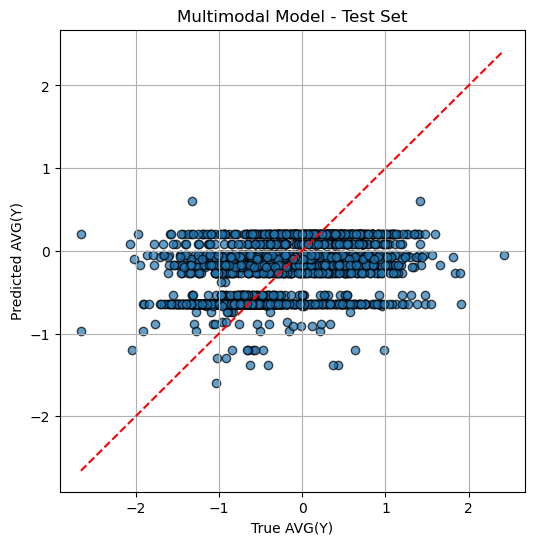

In [16]:
X_img_best = cropped_images[best_zoom_images]
n_samples = X_img_best.shape[0]
X_img_best = X_img_best.reshape(n_samples, -1)

X_spec_best = all_spectra[best_zoom_spectra]
X_spec_best = X_spec_best.reshape(n_samples, -1)

# Concatenate features horizontally
X_combined = np.concatenate([X_img_best, X_spec_best], axis=1)
print(f"\nCombined feature shape: {X_combined.shape}")

# Split the combined data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_combined, Y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define the parameter grid for the DecisionTreeRegressor for multimodal features
param_grid = {
    "max_depth": [5, 7],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [2, 4]
}
dt = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_dt = grid_search.best_estimator_
print(f"\nMultimodal - Best parameters: {grid_search.best_params_}")

# Evaluate on the validation set
y_val_pred = best_dt.predict(X_val)
mse_val = mean_squared_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)

# Evaluate on the test set
y_test_pred = best_dt.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print("\nMultimodal results:")
print(f"Validation MSE: {mse_val:.4f}, R2: {r2_val:.4f}")
print(f"Test MSE: {mse_test:.4f}, R2: {r2_test:.4f}")

# Plot scatter plot of true vs. predicted values on the test set for the multimodal model
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7, edgecolor='k')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("True AVG(Y)")
plt.ylabel("Predicted AVG(Y)")
plt.title("Multimodal Model - Test Set")
plt.grid(True)
plt.show()

## Fusion

Train, val, test sizes: (6075, 1280) (2025, 1280) (2026, 1280)


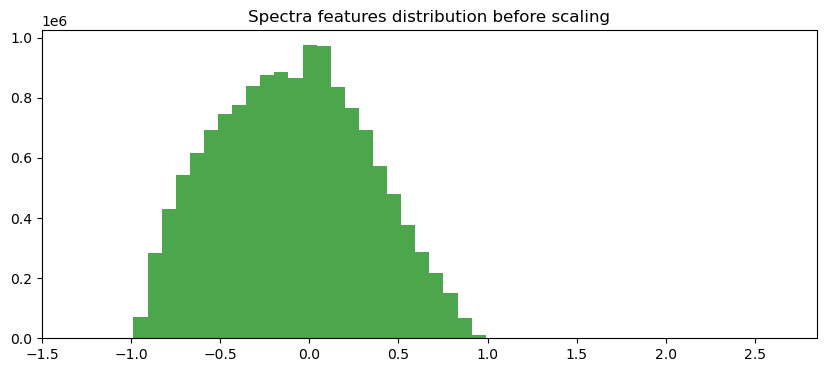

In [19]:
X_img_train, X_img_temp, X_spec_train, X_spec_temp, y_train, y_temp = train_test_split(
    X_img_best, X_spec_best, Y, test_size=0.4, random_state=42)
X_img_val, X_img_test, X_spec_val, X_spec_test, y_val, y_test = train_test_split(
    X_img_temp, X_spec_temp, y_temp, test_size=0.5, random_state=42)

print("Train, val, test sizes:", X_img_train.shape, X_img_val.shape, X_img_test.shape)

plt.figure(figsize=(10,4))
plt.hist(X_spec_train.ravel(), bins=50, color='green', alpha=0.7)
plt.title("Spectra features distribution before scaling")
plt.show()

## PCA

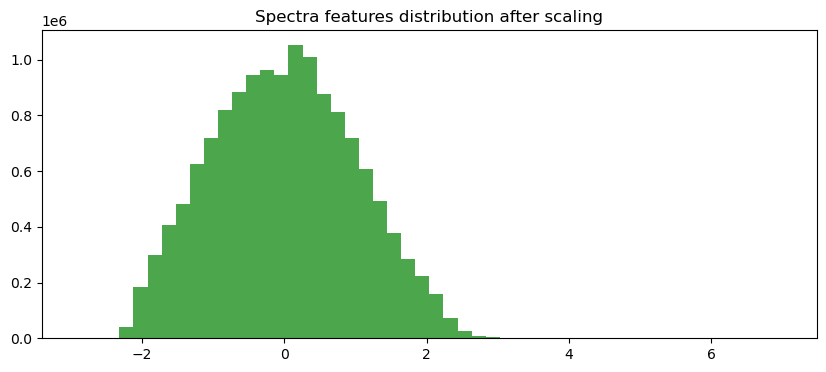

In [20]:
scaler_img = StandardScaler()
scaler_spec = StandardScaler()

X_img_train_scaled = scaler_img.fit_transform(X_img_train)
X_img_val_scaled = scaler_img.transform(X_img_val)
X_img_test_scaled = scaler_img.transform(X_img_test)

X_spec_train_scaled = scaler_spec.fit_transform(X_spec_train)
X_spec_val_scaled = scaler_spec.transform(X_spec_val)
X_spec_test_scaled = scaler_spec.transform(X_spec_test)

plt.figure(figsize=(10,4))
plt.hist(X_spec_train_scaled.ravel(), bins=50, color='green', alpha=0.7)
plt.title("Spectra features distribution after scaling")
plt.show()


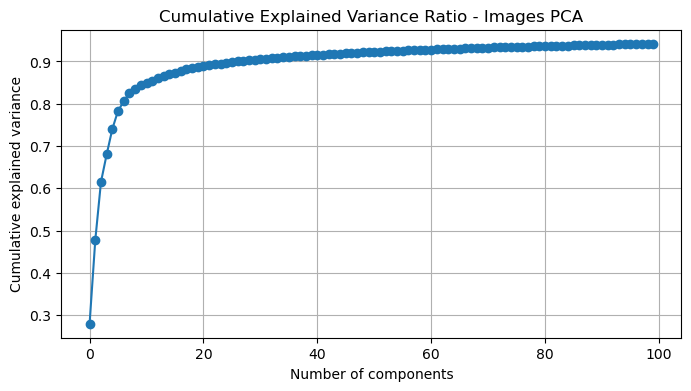

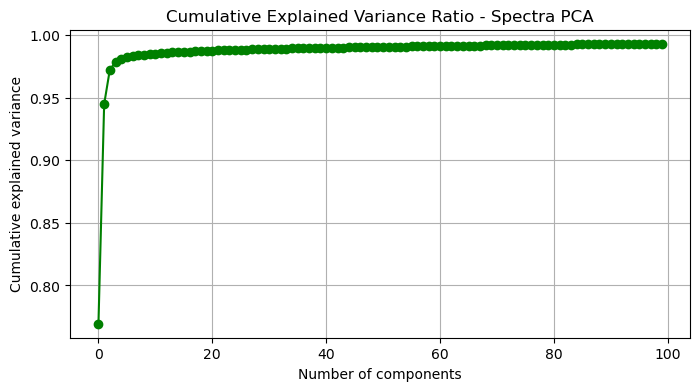

In [21]:
n_components_img = 100
n_components_spec = 100

pca_img = PCA(n_components=n_components_img)
X_img_train_pca = pca_img.fit_transform(X_img_train_scaled)
X_img_val_pca = pca_img.transform(X_img_val_scaled)
X_img_test_pca = pca_img.transform(X_img_test_scaled)

pca_spec = PCA(n_components=n_components_spec)
X_spec_train_pca = pca_spec.fit_transform(X_spec_train_scaled)
X_spec_val_pca = pca_spec.transform(X_spec_val_scaled)
X_spec_test_pca = pca_spec.transform(X_spec_test_scaled)

# Plot cumulative explained variance ratio for each PCA
plt.figure(figsize=(8,4))
plt.plot(np.cumsum(pca_img.explained_variance_ratio_), marker='o')
plt.title("Cumulative Explained Variance Ratio - Images PCA")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(np.cumsum(pca_spec.explained_variance_ratio_), marker='o', color='green')
plt.title("Cumulative Explained Variance Ratio - Spectra PCA")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.grid(True)
plt.show()


In [22]:
X_img_train_tensor = torch.tensor(X_img_train_pca, dtype=torch.float32)
X_img_val_tensor = torch.tensor(X_img_val_pca, dtype=torch.float32)
X_img_test_tensor = torch.tensor(X_img_test_pca, dtype=torch.float32)

X_spec_train_tensor = torch.tensor(X_spec_train_pca, dtype=torch.float32)
X_spec_val_tensor = torch.tensor(X_spec_val_pca, dtype=torch.float32)
X_spec_test_tensor = torch.tensor(X_spec_test_pca, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_img_train_tensor, X_spec_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_img_val_tensor, X_spec_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_img_test_tensor, X_spec_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [23]:
class FusionNet(nn.Module):
    def __init__(self, img_input_dim, spec_input_dim):
        super(FusionNet, self).__init__()
        # Image branch
        self.img_branch = nn.Sequential(
            nn.Linear(img_input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        # Spectra branch
        self.spec_branch = nn.Sequential(
            nn.Linear(spec_input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        # Fusion layers
        self.fusion = nn.Sequential(
            nn.Linear(32 + 32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x_img, x_spec):
        img_feat = self.img_branch(x_img)
        spec_feat = self.spec_branch(x_spec)
        # Concatenate features from both branches
        combined = torch.cat([img_feat, spec_feat], dim=1)
        out = self.fusion(combined)
        return out

# Instantiate the model
img_input_dim = n_components_img  # 100
spec_input_dim = n_components_spec  # 100
model = FusionNet(img_input_dim, spec_input_dim)
print(model)

# Set up loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

FusionNet(
  (img_branch): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (spec_branch): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (fusion): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


Epoch 1/100 - Train Loss: 0.4635, Val Loss: 0.4047
Epoch 2/100 - Train Loss: 0.3787, Val Loss: 0.3904
Epoch 3/100 - Train Loss: 0.3506, Val Loss: 0.3711
Epoch 4/100 - Train Loss: 0.3351, Val Loss: 0.3753
Epoch 5/100 - Train Loss: 0.3156, Val Loss: 0.3679
Epoch 6/100 - Train Loss: 0.3013, Val Loss: 0.3735
Epoch 7/100 - Train Loss: 0.2871, Val Loss: 0.3737
Epoch 8/100 - Train Loss: 0.2791, Val Loss: 0.3767
Epoch 9/100 - Train Loss: 0.2635, Val Loss: 0.3794
Epoch 10/100 - Train Loss: 0.2494, Val Loss: 0.3822
Epoch 11/100 - Train Loss: 0.2423, Val Loss: 0.3723
Epoch 12/100 - Train Loss: 0.2303, Val Loss: 0.3888
Epoch 13/100 - Train Loss: 0.2174, Val Loss: 0.4040
Epoch 14/100 - Train Loss: 0.2050, Val Loss: 0.3851
Epoch 15/100 - Train Loss: 0.1975, Val Loss: 0.3886
Epoch 16/100 - Train Loss: 0.1879, Val Loss: 0.4012
Epoch 17/100 - Train Loss: 0.1764, Val Loss: 0.4299
Epoch 18/100 - Train Loss: 0.1690, Val Loss: 0.4103
Epoch 19/100 - Train Loss: 0.1603, Val Loss: 0.4130
Epoch 20/100 - Train 

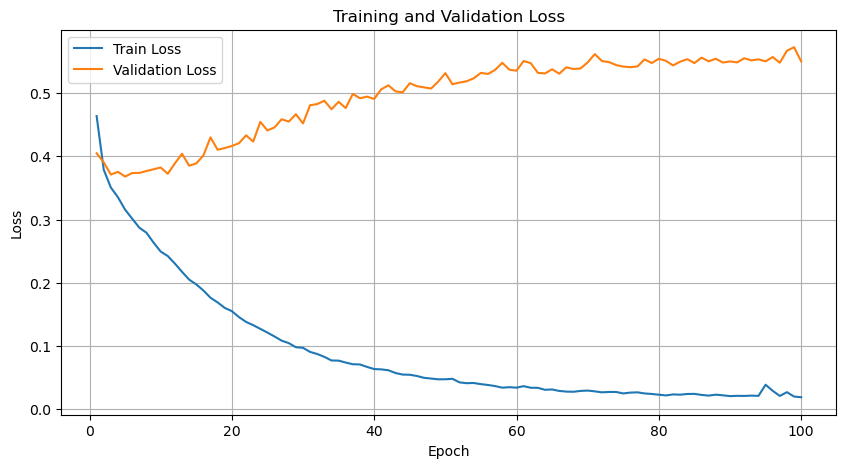

In [24]:
num_epochs = 100
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_epoch = -1
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_img, batch_spec, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_img, batch_spec)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_y.size(0)
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for batch_img, batch_spec, batch_y in val_loader:
            outputs = model(batch_img, batch_spec)
            loss = criterion(outputs, batch_y)
            running_val_loss += loss.item() * batch_y.size(0)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
    
    # Save best model
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_epoch = epoch
        best_model_state = model.state_dict()

# Load best model
model.load_state_dict(best_model_state)
print(f"Best epoch: {best_epoch+1} with validation loss: {best_val_loss:.4f}")

# Plot training and validation loss curves
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

Test MSE: 0.5656


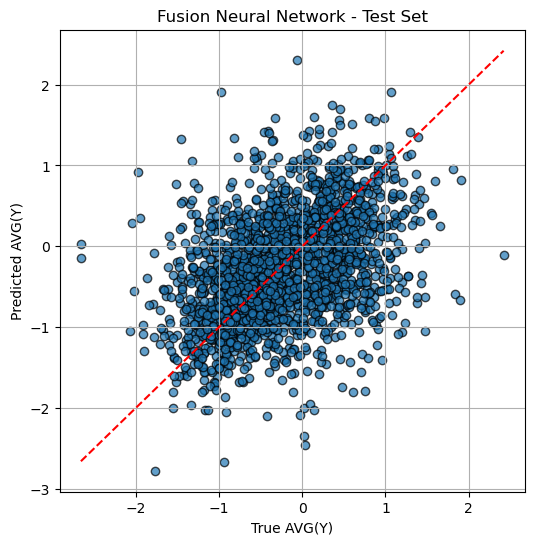

In [25]:
model.eval()
predictions = []
true_values = []
with torch.no_grad():
    for batch_img, batch_spec, batch_y in test_loader:
        outputs = model(batch_img, batch_spec)
        predictions.append(outputs.cpu().numpy())
        true_values.append(batch_y.cpu().numpy())
predictions = np.vstack(predictions)
true_values = np.vstack(true_values)

test_mse = np.mean((predictions - true_values)**2)
print(f"Test MSE: {test_mse:.4f}")

plt.figure(figsize=(6,6))
plt.scatter(true_values, predictions, alpha=0.7, edgecolor='k')
plt.plot([true_values.min(), true_values.max()], [true_values.min(), true_values.max()], 'r--')
plt.xlabel("True AVG(Y)")
plt.ylabel("Predicted AVG(Y)")
plt.title("Fusion Neural Network - Test Set")
plt.grid(True)
plt.show()